# **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab1.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "George Chouliaras"
NAME2 = "Jonathan Jeroen Beekman"
NAME3 = ""
EMAIL = "g.chouliaras@student.vu.nl"
EMAIL2 = ""
EMAIL3 = ""

---

# Lab 2: Classification

### Machine Learning 1, September 2017

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

Populating the interactive namespace from numpy and matplotlib


# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [3]:
from sklearn.datasets import fetch_mldata
# Fetch the data
mnist = fetch_mldata('MNIST original')
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

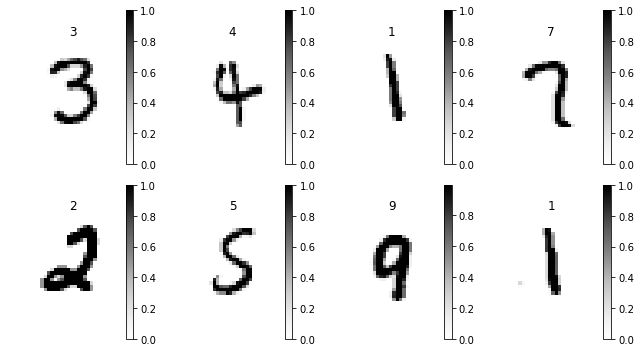

In [4]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

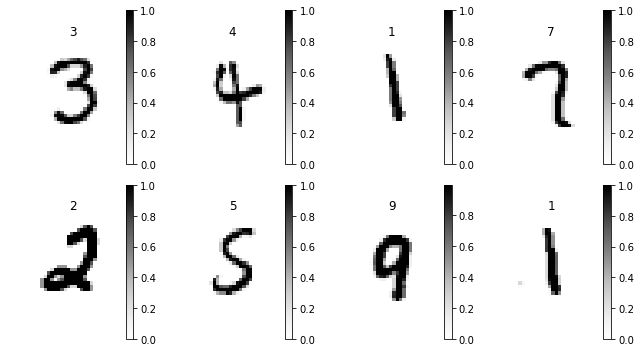

In [5]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log p_j}
\frac{\partial \log p_j}{\partial \log q_j}
+ \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1 \cdot 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
= 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$

For $j \neq t^{(n)}$:
$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



\begin{align}
    \frac{\partial \log Z}{\partial Z} &= \frac{1}{Z}\\
    \frac{\partial Z}{\partial \log q_j} &= \frac{\partial}{\partial \log q_j}\sum_ie^{\log q_i}\\
    &= e^{\log q_j} = q_j
\end{align}

For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&= 1 - \frac{q_j}{Z}
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&= - \frac{q_j}{Z}
\end{align}

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

---
$\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} = \mathbf{\delta}_j^q   \frac{\partial (\mathbf{w}_j^T \mathbf{x} + b_j)}{\partial W_{ij}}  = \mathbf{\delta}_j^q  \frac{\partial (\mathbf{w}_j^T \mathbf{x})}{\partial W_{ij}} = \mathbf{\delta}_j^q  \frac{\partial (\sum_i W_{ij} x_i)}{\partial W_{ij}} = \mathbf{\delta}_j^q x_i$

To write this in vector format we first find the derivative w.r.t $\mathbf{w}_j$:
$\frac{\partial \mathcal{L}^{(n)}}{\partial w_j} = \frac{\partial (\mathbf{w}_j^T \mathbf{x} + b_j - \log{ \sum_i \exp{\mathbf{w}_i^T \mathbf{x} + b_i} )}}{\partial w_j}  = \mathbf{x}^T - \frac{ \frac{\partial (\sum_i \exp{(\mathbf{w}_i^T \mathbf{x} + b_i)})}{\partial w_j} }{\sum_i \exp{(\mathbf{w}_i^T \mathbf{x} + b_i)}} = \mathbf{x}^T  - \frac{\exp{(\mathbf{w}_j^T \mathbf{x} + b_j)} \mathbf{x}^T}{\sum_i \exp{(\mathbf{w}_i^T \mathbf{x} + b_i)}} = \mathbf{x}^T (1 - \frac{q_j}{\sum_i \exp{(\log{q_i})}}) = \mathbf{x}^T \delta_j^q$

Hence $\nabla_{\mathbf{w}_j}\mathcal{L}^{(n)} = (\frac{\partial \mathcal{L}^{(n)}}{\partial w_j})^T  = \delta_j^q \mathbf{x}$

### 1.1.2 Implement gradient computations (10 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [6]:
# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
def logreg_gradient(x, t, w, b):
    logq = (np.dot(x,w) + b).T


    #find maximum
    max_log = np.max(logq)
    #use log-sum-exp trick
    logp = logq - max_log - log(sum(exp(logq - max_log)))
    
    #we use: q_j/Z = exp(logp_j)

    #if j not equal t, compute d = - exp(logp)
    d= - np.exp(logp)
    #if j = t , change only the element d[t] with the value for j=t found in 1.1.1
    d[t] = 1 - np.exp(logp[t])

        
    dL_db = d
    dL_dw = np.dot(d,x).T
    logp = logp.T

    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze()


In [7]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
Likelihood:	 -2.2959726720744777

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [-0.04518971 -0.06758809 -0.07819784 -0.09077237 -0.07584012 -0.06365855]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [-0.10020327 -0.09977827 -0.1003198   0.89933657 -0.10037941 -0.10072863
 -0.09982729 -0.09928672 -0.09949324 -0.09931994]
i in {0,...,9}; j in M


In [8]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide can compute the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 6.43389446029e-07
Finite difference error grad_b: 5.2351174901e-08



### 1.1.3 Stochastic gradient descent (10 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1E-6`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [9]:
def sgd_iter(x_train, t_train, W, b):
    # Shuffle the indices
    indices = np.arange(shape(x_train)[0])
    np.random.seed(123)
    np.random.shuffle(indices)
    #set learning rate
    eta = 1E-6;
    logp_train = 0
    for i in indices:
        #reshape x_train[i,:] in order for np.dot(d,x) to be valid 
        x_r = reshape(x_train[i,:], (1,len(x_train[i,:])))
        logpt, grad_w, grad_b = logreg_gradient(x_r, t_train[i], W, b)
        #update
        W = W + eta * grad_w
        b = b + eta * grad_b
        
    #we compute the log-likelihood of the training set using the last W,b
    for i in indices:
        x_r = reshape(x_train[i,:], (1,len(x_train[i,:])))
        logpt, _, _ = logreg_gradient(x_r, t_train[i], W, b)
        #log-likelihood of the training set is the sum of all the data points 
        logp_train += logpt
        
    return logp_train, W, b

In [10]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)


## 1.2. Train

### 1.2.1 Train (10 points)
Perform 10 SGD iterations through the trainingset. Plot (in one graph) the conditional log-probability of the trainingset and validation set after each iteration.


Performing SGD iteration 1 ...
Performing SGD iteration 2 ...
Performing SGD iteration 3 ...
Performing SGD iteration 4 ...
Performing SGD iteration 5 ...
Performing SGD iteration 6 ...
Performing SGD iteration 7 ...
Performing SGD iteration 8 ...
Performing SGD iteration 9 ...
Performing SGD iteration 10 ...


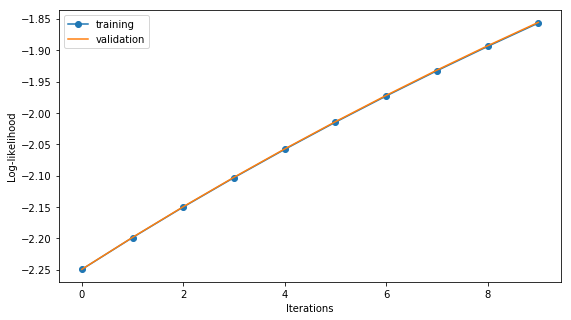

In [11]:

def test_sgd(x_train, t_train, w, b):
    #set number of iterations
    n_iter = 10;
    #create vectors which contain log-likelihood of training and validation set after each iteration
    logp_train = np.zeros((n_iter,1))
    logp_valid = np.zeros((n_iter,1))
    
    for i in range(n_iter):
        #perform sgd on training set
        print('Performing SGD iteration '+str(i+1) + ' ...')
        logp_train[i], w, b = sgd_iter(x_train,t_train,w,b)
        
        #compute logp for validation set
        for j in range(len(t_valid)):
        
            logq = (np.dot(x_valid[j,:],w) + b).T
            #find maximum
            max_log = np.max(logq)
            #use log-sum-exp trick
            logp = logq - max_log - log(sum(exp(logq - max_log)))
            logp_valid[i] +=logp[t_valid[j]]
            
    #we normalize the log-likelihoods in order to be independent of dataset size, for the comparison to be more clear 
    logp_train_n = logp_train / shape(x_train)[0]
    logp_valid_n = logp_valid / shape(x_valid)[0]
    
    fig, ax = plt.subplots();    
    plt.plot(range(len(logp_train)),logp_train_n, label = 'training',marker = 'o');
    plt.plot(range(len(logp_valid)),logp_valid_n,label = 'validation');
    plt.legend()
    xlim = (0,9)
    xlabel('Iterations')
    ylabel('Log-likelihood')
    return w,b
    
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
w,b = test_sgd(x_train, t_train, w, b)

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


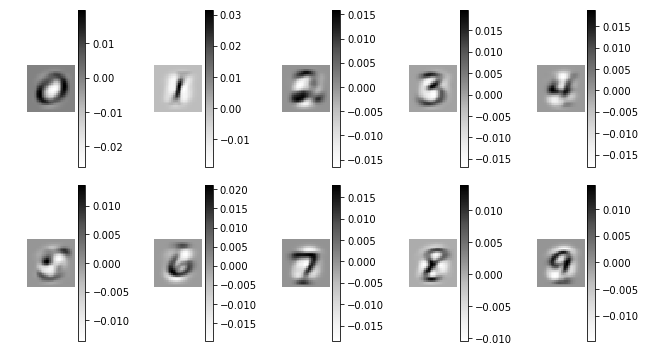

In [15]:
#we transpose W and treat each row as an image, we do that in order to insert it in the plot_digits function
data = w.T
#plot 5 columns
num_cols = 5

plot_digits(data, num_cols, targets=None, shape=(28,28))

**Describe in less than 100 words why these weights minimize the loss**

We know that the loss function for the logistic regression (cross-entropy) is convex and hence it has one global minimum. However since it has not closed form we cannot find an analytic solution and this is why we use SGD to find the weights that minimize the loss (or maximize the likelihood). Our learning rate is very small and hence we know that the algorithm will not diverge. From 1.2.1 we saw that the w's of the last iteration, achieve the maximum likelihood both in training and validation set and thus, we know that these weights minimize the loss.  

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.
Ask yourself if these results make sense.

Digits with highest probability:


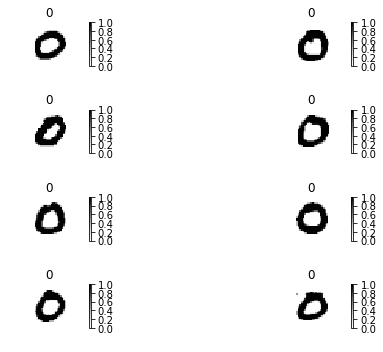

Digits with lowest probability:


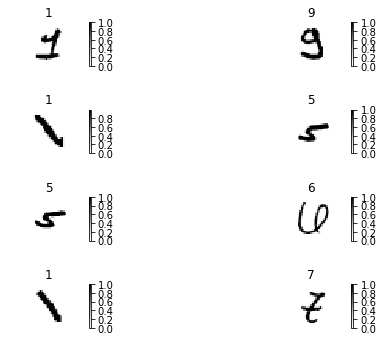

In [16]:
#Compute log-likelihood for validation set
logq = (np.dot(x_valid,w) + b).T
#find maximum
max_log = np.max(logq)
#use log-sum-exp trick
logp = logq - max_log - log(sum(exp(logq - max_log)))
p_valid = np.zeros(shape(x_valid)[0],)
for i in range(shape(x_valid)[0]):
    p_valid[i] = logp[t_valid[i],i]

#sort the likelihoods in the validation set
p_val_sort = sort(p_valid)
#find 8 lowest and 8 highest likelihoods
lowest8 = p_val_sort[np.r_[0:8]]
highest8 = p_val_sort[np.r_[-8:0]]
#create matrices for the indices
low_ind = []
high_ind = []
#find the indices of the digits with the highest and lowest probabilities
for i in range(shape(x_valid)[0]):
    for j in lowest8:
        if (p_valid[i] == j):
            low_ind.append(i)
    for j in highest8:
        if (p_valid[i] == j):
            high_ind.append(i)
        
#Plot the digits

#Highest probability digits
print('Digits with highest probability:')
plot_digits(x_valid[high_ind], 2, targets=t_valid[high_ind], shape=(28,28))
#lowest probability digits
print('Digits with lowest probability:')
plot_digits(x_valid[low_ind], 2, targets=t_valid[low_ind], shape=(28,28))

#We observe that the digits with highest probabilities are all zeros, since they are very easy to be recognized.
#We see that the lowest probability digits have wierd typewritting and can easily be misinterpreted for another digit.

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron wil have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$.

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

---

We first find $\delta_j^h$:

For $j = t^{(n)}: \delta_j^h = 
\frac{\partial \log q_j}{\partial \log q_j} \frac{\partial \log{q_j}}{\partial h_j}
- 
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} \frac{\partial \log{q_j}}{\partial h_j} = \left(\frac{\partial \log q_j}{\partial \log q_j} 
- 
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}  \right) \frac{\log{q_j}}{\partial h_j} = \delta_j^q \frac{\partial (\mathbf{w}_j^T \mathbf{h} + b_j)}{\partial h_j} = \delta_j^q \mathbf{w}_j^T$


For $j \neq t^{(n)}: \delta_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}  \frac{\partial \log{q_j}}{\partial h_j} = \delta_j^q \mathbf{w}_j^T $

Alternatively, we can find $\delta^h$ in vector form as:

$\delta^h =  \frac{\partial \mathcal{L}^{(n)}}{\partial \log q} \frac{\partial \log q}{\partial \mathbf{h}} = \delta^q \frac{\partial (\mathbf{W}^T \mathbf{h} + \mathbf{b})}{\partial \mathbf{h}} = \delta^q \mathbf{W}^T$ 

Next, we find the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$:

$\frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{W}} = \frac{\partial \mathcal{L}^{(n)}}{\partial \log{q}} \frac{\partial \log{q}}{\partial \mathbf{W}} = \delta^q \frac{\partial (\mathbf{W}^T \mathbf{h} + \mathbf{b})}{\partial \mathbf{W}} = \delta^q \mathbf{h} $


$\frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{b}} = \frac{\partial \mathcal{L}^{(n)}}{\partial \log{q}} \frac{\partial \log{q}}{\partial \mathbf{b}} = \delta^q  \cdot 1 = \delta^q $


$ \frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{V}} = \frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{h}} \frac{\partial \bh}{\partial \bV} = \delta^h \frac{\partial (\sigma(\bV^T \bx + \ba))}{\partial \bV} = \delta^h  \sigma(\bV^T \bx + \ba) (1 - \sigma(\bV^T \bx + \ba))  \frac{\partial (\bV^T \bx + \ba)}{\partial V}  = \delta^h \sigma(\bV^T \bx + \ba) (1 - \sigma(\bV^T \bx + \ba)) \bx$ 


$\frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{a}} = \frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{h}} \frac{\partial \bh}{\partial \ba} = \delta^h \sigma(\bV^T \bx + \ba) (1 - \sigma(\bV^T \bx + \ba))  \frac{\partial (\sigma(\bV^T \bx + \ba))}{\partial \ba}  = \delta^h \sigma(\bV^T \bx + \ba) (1 - \sigma(\bV^T \bx + \ba)) $


The multilayer perceptron is almost equal to the previous logistic regression but has an extra hidden layer $\bh$. Since $\bb$ does not depend on the hidden layer, $\nabla_{\bb} \mathcal{L}^{(n)}$ is the same as in the logistic regression model. However, in the perceptron $\bW^T$ is multiplied by the hidden layer within $\log q$ while in the logistic regression it was multiplied directly by the input $\bx$. This is why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ in both cases is similar, but not exactly the same.

## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

---
Since we have likelihood and prior, we can find the log-posterior, by adding the logarithms of likelihood and prior. Then we can find the MAP estimates of the parameters by finding the derivatives of the log-posterior w.r.t the parameters and by setting these derivatives to zero. Then we solve for the corresponding parameter and we find maximum a posteriori solution of the parameters. Note that a MAP approach is equivalent to regularized maximum likelihood and the regularizer can be viewed as the logarithm of the prior parameter distribution, in our case a Gaussian prior. This can help us to prevent overfitting.

## 2.3. Implement and train a MLP (15 points)

Implement a MLP model with a single hidden layer of **20 neurons**. 
Train the model for **10 epochs**.
Plot (in one graph) the conditional log-probability of the trainingset and validation set after each two iterations, as well as the weights.

- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [47]:
# Write all helper functions here

def sigmoid(x):
    s = 1 / (1 + exp(-x))
    return s

def gradients(x,t,V,W,a,b):
    #use np.apply_along_axis to apply the sigmoid function to every row of the matrix np.dot(V.T,x.T) + a
    #We do that in order to avoid using a for loop
    h = np.apply_along_axis(sigmoid, 1, np.dot(V.T,x.T) + a)

    #compute logq
    logq = (np.dot(W.T,h) + b)
    max_log = np.max(logq)
    #use log-sum-exp trick to compute logp
    logp = logq - max_log - log(sum(exp(logq - max_log)))

    #Compute delta^q:10x1 vector

    #q_j/Z = exp(logp_j)

    #if j not equal t
    dq= - exp(logp)
    #if j = t  
    dq[t] = 1 - exp(logp[t])

    #Compute delta^h: Lx1 vector
    dh = np.dot(dq.T,W.T).T

    #Compute derivatives

    #dL_dW: Lx10
    dL_dW = np.dot(dq,h.T).T

    #dL_db: 10x1 vector
    dL_db = dq

    #dL_dV:784xL matrix
    #we split the product in 2 parts
    #We first multiply dh, h and 1-h elementwise
    c = np.multiply(np.multiply(dh,h),1-h)
    #then we take the dot product with x
    dL_dV = np.dot(c,x).T

    #dL_da: Lx1 vector
    dL_da = c
    
    return dL_dW, dL_db, dL_dV, dL_da, logp[t]

def sgd_iter_mlp(x_train, t_train, W, b,V,a,eta):
    # Shuffle the indices
    indices = np.arange(shape(x_train)[0])
    np.random.seed(123)
    np.random.shuffle(indices)
    logp_train = 0
    for i in indices:
        #again we reshape x in order to put it in gradients function as 1x784
        x_r = reshape(x_train[i,:], (1,len(x_train[i,:])))
        dL_dW, dL_db, dL_dV, dL_da, logpt = gradients(x_r,t_train[i],V,W,a,b)
    
        #perform updates
        W = W + eta * dL_dW
        b = b + eta * dL_db
        V = V + eta * dL_dV
        a = a + eta * dL_da
    
    #we compute the log-likelihood of the training set using the last W,b
    for i in indices:
        x_r = reshape(x_train[i,:], (1,len(x_train[i,:])))
        _, _, _, _, logpt = gradients(x_r,t_train[i],V,W,a,b)
        logp_train += logpt

    return logp_train, W,b,V,a

Performing SGD iteration 1 ...
Performing SGD iteration 2 ...
Performing SGD iteration 3 ...
Performing SGD iteration 4 ...
Performing SGD iteration 5 ...
Performing SGD iteration 6 ...
Performing SGD iteration 7 ...
Performing SGD iteration 8 ...
Performing SGD iteration 9 ...
Performing SGD iteration 10 ...


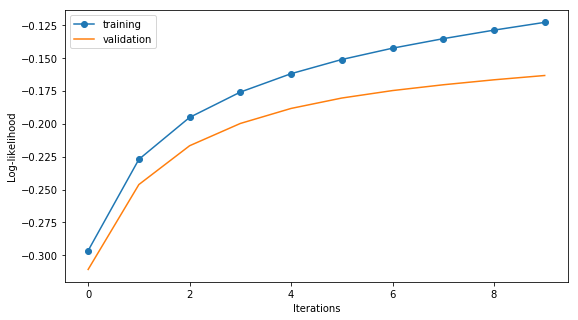

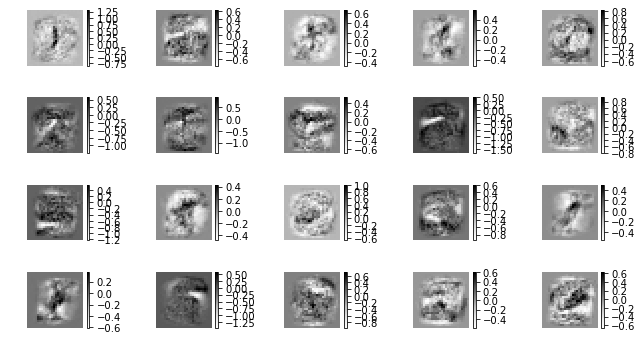

In [49]:
# Write training code here:
# Plot the conditional loglikelihoods for the train and validation dataset after every iteration.
# Plot the weights of the first layer.

def train_mlp(n_iter, L,W,V,b,a,x_train,t_train,x_valid,t_valid,eta):
    #create vectors which contain log-likelihood of training and validation set after each iteration
    logp_train = np.zeros((n_iter,1))
    logp_valid = np.zeros((n_iter,1))

    for i in range(n_iter):
        #perform sgd on training set
        print('Performing SGD iteration '+str(i+1) + ' ...')
        logp_train[i], W,b,V,a = sgd_iter_mlp(x_train, t_train, W, b,V,a,eta)
    
        #compute logp for validation set
        for j in range(len(t_valid)):
            #reshape as before to have x_r_v as 1x784
            x_r_v = reshape(x_valid[j,:], (1,len(x_valid[j,:])))
            h = np.apply_along_axis(sigmoid, 1, np.dot(V.T,x_r_v.T) + a)
            #compute logq
            logq = (np.dot(W.T,h) + b)
            max_log = np.max(logq)
            #use log-sum-exp trick to compute logp
            logp = logq - max_log - log(sum(exp(logq - max_log)))
            logp_valid[i] +=logp[t_valid[j]]

        
    #we normalize the log-likelihoods in order for the comparison to be more clear 
    logp_train_n = logp_train / shape(x_train)[0]
    logp_valid_n = logp_valid / shape(x_valid)[0]
    
    fig, ax = plt.subplots();    
    plt.plot(range(len(logp_train)),logp_train_n, label = 'training',marker = 'o');
    plt.plot(range(len(logp_valid)),logp_valid_n,label = 'validation');
    plt.legend();
    xlim = (0,9);
    xlabel('Iterations');
    ylabel('Log-likelihood');
    
    fig2, ax2 = plt.subplots(); 
    data = V.T
    #plot 5 columns
    num_cols = 5

    plot_digits(data, num_cols, targets=None, shape=(28,28))

    return W,V,b,a
    
    
    
np.random.seed(99)
n_iter = 10;
L = 20
W = np.random.normal(size=(L,10), scale=0.001)
V = np.random.normal(size=(28*28,L), scale=0.001)
b = np.zeros((10,1))
a = np.zeros((L,1))
eta = 1E-2


W,V,b,a = train_mlp(n_iter, L,W,V,b,a,x_train,t_train,x_valid,t_valid,eta)


#With eta = 1E-2, and scales 0.001-> mis.rate on test set = 5.23%

    

### 2.3.1. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

---
In logistic regression we use basis functions that are fixed in advance. On the other hand with MLP we use adaptive basis functions which means that we learn the feature vectors (they adapt to the data). Moreover, the logistic regression is a linear parametric model, while the MLP is a non-linear parametric model. These differences between the 2 models lead to higher performance of the MLP compared to the logistic regression.

### 2.3.1. Less than 250 misclassifications on the test set (10 bonus points)

You receive an additional 10 bonus points if you manage to train a model with very high accuracy: at most 2.5% misclasified digits on the test set. Note that the test set contains 10000 digits, so you model should misclassify at most 250 digits. This should be achievable with a MLP model with one hidden layer. See results of various models at : `http://yann.lecun.com/exdb/mnist/index.html`. To reach such a low accuracy, you probably need to have a very high $L$ (many hidden units), probably $L > 200$, and apply a strong Gaussian prior on the weights. In this case you are allowed to use the validation set for training.
You are allowed to add additional layers, and use convolutional networks, although that is probably not required to reach 2.5% misclassifications.

In [6]:
predict_test = np.zeros(len(t_test))

#We create the function that computes the logp using the tuned parameters, in order to predict
def predict(W,V,a,b,x):
    h = np.apply_along_axis(sigmoid, 1, np.dot(V.T,x.T) + a)

    #compute logq
    logq = (np.dot(W.T,h) + b)
    max_log = np.max(logq)
    #use log-sum-exp trick to compute logp
    logp = logq - max_log - log(sum(exp(logq - max_log)))

    return logp



In [25]:
def train_mlp_largeL(n_iter, L,W,V,b,a,x_train,t_train,eta):
    #create vectors which contain log-likelihood of training and validation set after each iteration
    logp_train = np.zeros((n_iter,1))

    for i in range(n_iter):
        #perform sgd on training set
        print('Performing SGD iteration '+str(i+1) + ' ...')
        logp_train[i], W,b,V,a = sgd_iter_mlp(x_train, t_train, W, b,V,a,eta)
 
    #we normalize the log-likelihoods in order for the comparison to be more clear 
    logp_train_n = logp_train / shape(x_train)[0]
    
    fig, ax = plt.subplots();    
    plt.plot(range(len(logp_train)),logp_train_n, label = 'training',marker = 'o');
    plt.legend();
    xlim = (0,9);
    xlabel('Iterations');
    ylabel('Log-likelihood');
    return W,V,b,a

Iteration for n_iter = 15...
Performing SGD iteration 1
Performing SGD iteration 2
Performing SGD iteration 3
Performing SGD iteration 4
Performing SGD iteration 5
Performing SGD iteration 6
Performing SGD iteration 7
Performing SGD iteration 8
Performing SGD iteration 9
Performing SGD iteration 10
Performing SGD iteration 11
Performing SGD iteration 12
Performing SGD iteration 13
Performing SGD iteration 14
Performing SGD iteration 15
Misclassification rate: [ 2.3]% L: 15
Iteration for n_iter = 20...
Performing SGD iteration 1
Performing SGD iteration 2
Performing SGD iteration 3
Performing SGD iteration 4
Performing SGD iteration 5
Performing SGD iteration 6
Performing SGD iteration 7
Performing SGD iteration 8
Performing SGD iteration 9
Performing SGD iteration 10
Performing SGD iteration 11
Performing SGD iteration 12
Performing SGD iteration 13
Performing SGD iteration 14
Performing SGD iteration 15
Performing SGD iteration 16
Performing SGD iteration 17
Performing SGD iteration 1

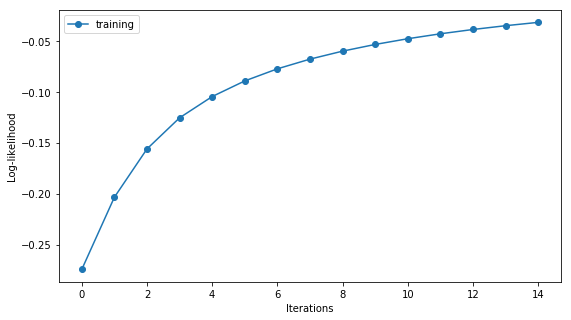

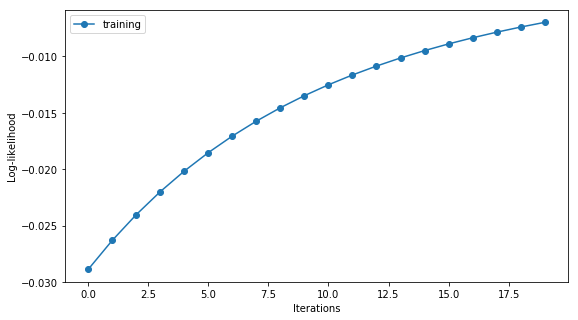

In [28]:
#Tuning


#tried eta = [0.1,0.01,0.001,0.0001], 
#best misclassification rate in validation set, with eta = 0.01 : 4.05%
#eta = 0.1 : 4.79%
#eta =  0.001: 4.11%
#eta=0.0001 : 4.08%


#L = 50 : 3.21%
#L = 80 : 3%
#L = 120 : 2.95 %
#L = 160 : 2.82 % 
#L = 200: 2.59 % 
#L = 210: 2.57% 
#L = 215: 2.67%
#L = 220: 2.58%
# L = 210 and n_iter = 15 : 2.3%
# L = 210 and n_iter = 20: 1.94% <-- use this setting for the test set, train in both training and validation

#tried n_iter = 8,9,10, with n_iter = 10 mis_rate = 2.02%

np.random.seed(99)
n_iter = [15,20];
L = 210;
W = np.random.normal(size=(L,10), scale=0.001)
V = np.random.normal(size=(28*28,L), scale=0.001)
a = np.zeros((L,1))
b = np.zeros((10,1))
eta = 0.01
mis_rate = np.empty((len(n_iter),1))
for i in range(len(n_iter)):
   

    print('Iteration for n_iter = ' + str(n_iter[i]) + '...')
    W,V,b,a = train_mlp_largeL(n_iter[i],L,W,V,b,a,x_train,t_train,eta)
    logp_valid = predict(W,V,a,b,x_valid)

    #use argmax to get indices of maximum values along axis 0 (the columns)
    predict_valid = numpy.argmax(logp_valid,axis=0)    
    n_errors = np.sum(predict_valid != t_valid)
    mis_rate[i] = n_errors/len(t_valid)
    print('Misclassification rate: '+ str(mis_rate[i]*100) + '%' + ' L: ' + str(n_iter[i]))

Performing SGD iteration 1
Performing SGD iteration 2
Performing SGD iteration 3
Performing SGD iteration 4
Performing SGD iteration 5
Performing SGD iteration 6
Performing SGD iteration 7
Performing SGD iteration 8
Performing SGD iteration 9
Performing SGD iteration 10
Performing SGD iteration 11
Performing SGD iteration 12
Performing SGD iteration 13
Performing SGD iteration 14
Performing SGD iteration 15
Performing SGD iteration 16
Performing SGD iteration 17
Performing SGD iteration 18
Performing SGD iteration 19
Performing SGD iteration 20


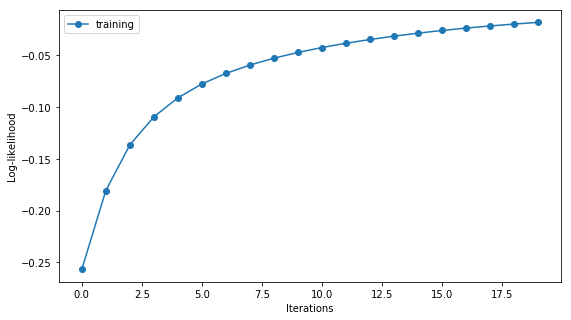

In [30]:
#Model with more neurons for better performance
#L = 210, eta = 0.01 and n_iter = 20: train in training and validation set, test error: 2.28%

np.random.seed(99)
n_iter = 20;
L = 210
W = np.random.normal(size=(L,10), scale=0.001)
V = np.random.normal(size=(28*28,L), scale=0.001)
b = np.zeros((10,1))
a = np.zeros((L,1))
eta = 0.01

#merge training and validation set
x_merged = np.concatenate((x_train, x_valid), axis=0)
t_merged = np.concatenate((t_train, t_valid), axis=0)

W,V,b,a = train_mlp_largeL(n_iter,L,W,V,b,a,x_merged,t_merged,eta)

In [38]:
#Predict in test set
logp_test = predict(W,V,a,b,x_test)

#use argmax to get indices of maximum values along axis 0 (the columns)
predict_test = numpy.argmax(logp_test,axis=0)    
n_errors = np.sum(predict_test != t_test)
mis_rate = n_errors/len(t_test)
print('Misclassification rate on test set: '+ str(mis_rate*100) + '%')

Misclassification rate on test set: 5.23%


In [32]:
assert predict_test.shape == t_test.shape
n_errors = np.sum(predict_test != t_test)
print('Test errors: %d' % n_errors)

Test errors: 228
